In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.10.0'

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


<h1> Data Preprocessing

<h3> Training set

In [4]:
#### Transformation to avoid overfitting 
## Image augmentation use Keras
## maybe some geometric transformation like shit zoom etc

#### We can find the full list of preprocessing form keras from here https://keras.io/api/preprocessing/image/
### Please take screen shot of the methods we decided to use and put in our report of 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_set = train_datagen.flow_from_directory(
    'data_cnn/train',
    target_size=(256,256),    ### might need to reduce the size to 64 or something to reduce training time and compare metrics
    batch_size=32,
    class_mode='binary'
)

Found 3640 images belonging to 2 classes.


<h3> Test set

In [5]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_set = test_datagen.flow_from_directory(
    'data_cnn/val',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 911 images belonging to 2 classes.


<h1> Build CNN

In [6]:
### Initialize CNN

### ARHHHH I hate apple. Apple silicon is UMA, not NUMA which is a unified memory architecture. 
### tensorflow-metal is broken. Might need a new env for cudatoolkit=9.0 && tensorflow-gpu=1.11.0
### will test this out later
cnn = tf.keras.models.Sequential()

Metal device set to: Apple M1 Pro


2022-11-15 19:18:49.636993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 19:18:49.637136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
#### Convolution


### Need more hyper parameter tuing and maybe Batch normalization is a good idea as well
### I started by picking a Classic architecture which has a 32 filters in first convolutional layers 
### follow by another 32 filters on second 

### Later decided on 32 32 and 64 performs slighty better


cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256,256,3]))

In [8]:
##### Pooling 
### We are using Max pooling but can also experiment with mean pooling or sum pooling MORE hyper parameters tuning needed


cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [9]:
#### Second layer of Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))


In [10]:
#### third layer of Convolution
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))


In [11]:
#### Flattening

cnn.add(tf.keras.layers.Flatten())

In [12]:
#### Fully connected layer

### using 128 hidden neurons need more tuning
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [13]:
### Output layer

## binary classification uses sigmoid multiclass will use softmax
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

<h1> Train CNN

In [14]:
### Compile CNN

## I choose to stick with adam because it performs well on stochastic gradient descent. MSE is not good for adjusting that
cnn.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [15]:
%%time
########## Train and evaluate ##########


model = cnn.fit(x=train_set, validation_data=test_set, epochs=15)

Epoch 1/15


2022-11-15 19:18:50.075451: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 19:18:50.396426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.8266

2022-11-15 19:19:15.625460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - 32s 275ms/step - loss: 0.3898 - accuracy: 0.8266 - val_loss: 0.2125 - val_accuracy: 0.9166
Epoch 2/15
114/114 [==============================] - 31s 269ms/step - loss: 0.1707 - accuracy: 0.9434 - val_loss: 0.1363 - val_accuracy: 0.9407
Epoch 3/15
114/114 [==============================] - 31s 267ms/step - loss: 0.1336 - accuracy: 0.9560 - val_loss: 0.1555 - val_accuracy: 0.9473
Epoch 4/15
114/114 [==============================] - 30s 267ms/step - loss: 0.0941 - accuracy: 0.9714 - val_loss: 0.1179 - val_accuracy: 0.9726
Epoch 5/15
114/114 [==============================] - 31s 271ms/step - loss: 0.0813 - accuracy: 0.9764 - val_loss: 0.0769 - val_accuracy: 0.9780
Epoch 6/15
114/114 [==============================] - 31s 270ms/step - loss: 0.0850 - accuracy: 0.9701 - val_loss: 0.0757 - val_accuracy: 0.9813
Epoch 7/15
114/114 [==============================] - 31s 272ms/step - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.1109 - val_accuracy: 0.9

<h1>Accuracy, Loss & ROC 

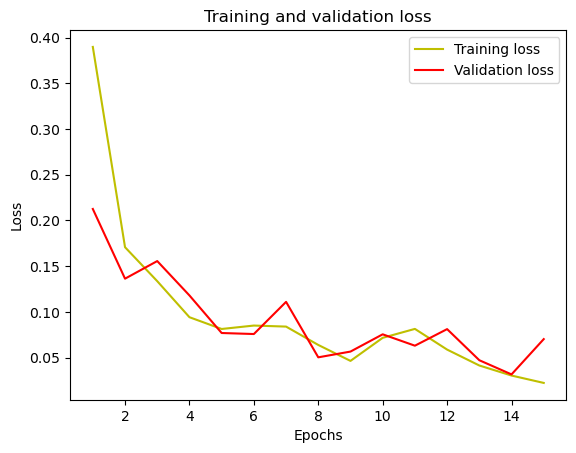

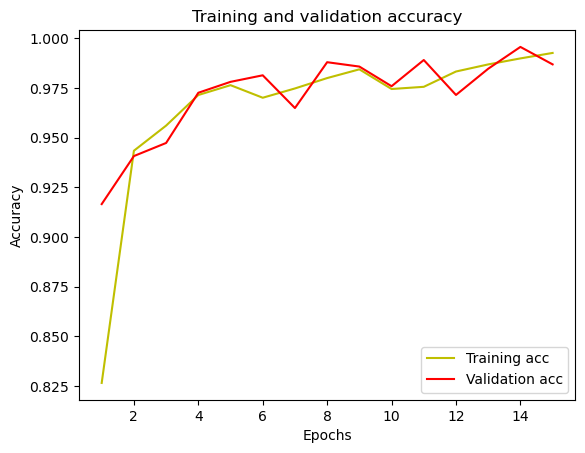

In [35]:
import matplotlib.pyplot as plt

loss = model.history['loss']
val_loss = model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
_, acc = cnn.evaluate(test_set)
print("Accuracy = ", (acc * 100.0), "%")

29/29 [==============================] - 6s 203ms/step - loss: 0.0832 - accuracy: 0.9802
Accuracy =  98.02414774894714 %


In [20]:
cnn.save('CNN_TURBINE')

INFO:tensorflow:Assets written to: CNN_TURBINE/assets


INFO:tensorflow:Assets written to: CNN_TURBINE/assets


In [21]:
cnn.save('CNN_TURBINE_H5', save_format="h5")

<h1> Make predictions

In [152]:
import numpy as np
from keras.preprocessing import image
import keras

test_image = keras.utils.load_img("mapbox_right.jpeg")
test_image = test_image.resize((256, 256))
test_image = keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = cnn.predict(test_image/255.0)

test_set.class_indices
if result[0][0] > 0.5:
    prediction = 'wind_turbine'
else:
    prediction = 'not_wind_turbinne'

1/1 [==============================] - 0s 13ms/step


In [153]:
prediction

'wind_turbine'

In [154]:
result

array([[0.990862]], dtype=float32)